In [46]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

from keras.layers import Dense, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dropout, Activation, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

In [47]:
# Multi-input classifier - boundary outlier samples

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self):
        self.number_of_classes = 2
        self.input_dim = 2
        self.epochs = 200
        self.batch_size = 32
        # There are 2 inlier circles
        # Inlier circle centers on the 1st axis; for all other dimensions, the centers are at 0.
        self.x1 = -10
        self.x2 = +10
        self.r = 5
        # Number of inlier samples for each class
        self.n = 1000
        # width of the outlier outer square side
        self.s = 100

        self.data, self.labels, self.data_out, self.labels_out = self.get_data()
        # Oultiers from rectagle outside 2 circles
        self.data_outlier, self.labels_outlier = self.get_outlier_data()

        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)
        self.X_train_out, self.X_test_out, self.y_train_out, self.y_test_out = train_test_split(self.data_out, self.labels_out, test_size=0.5, shuffle=True,
                                                            random_state=1)
        self.multi_input_classifier, self.model = self.get_model()


        self.mu = np.mean(np.concatenate((self.X_train, self.X_train_out), axis=0), axis=0)
        self.sigma = np.std(np.concatenate((self.X_train, self.X_train_out), axis=0), axis=0)

        self.data = self.preprocess_data(self.data)
        self.data_out = self.preprocess_data(self.data_out)
        self.data_outlier = self.preprocess_data(self.data_outlier)
        self.X_train = self.preprocess_data(self.X_train)
        self.X_test = self.preprocess_data(self.X_test)
        self.X_train_out = self.preprocess_data(self.X_train_out)
        self.X_test_out = self.preprocess_data(self.X_test_out)


    def preprocess_data(self, x):
        # return (x-self.mu)/self.sigma
        return x


    # return True if point p (a list) lies inside a hypersphere centered at the origin with radius r
    def is_in_hypersphere(self, r, p):
        p = np.array(p)
        return np.sum(p*p) <= r**2


    # return True if point p (a list) lies inside a hypersphere centered at the (x, 0, 0, ...) with radius r
    def is_in_hypersphere_centered_at(self, x, r, p):
        p = np.array(p)
        p[0] -= x
        return np.sum(p*p) <= r**2


    # uniformly sample a point from a square centered at the origin with side = s
    def sample_point_from_square(self, s):
        p = []
        # first point
        for i in range(0, self.input_dim):
            p.append(np.random.uniform(-1*s/2, s/2, 1))
        return p


    # sample points using rejection sampling from a sphere centered at the origin
    def sample_point_from_hypersphere(self, r):
        p = self.sample_point_from_square(2*r)
        while not self.is_in_hypersphere(r, p):
            p = self.sample_point_from_square(2*r)
        return p

    
    # sample from a hypersphre with rejection sampling
    def get_hypersphere_data(self, x, r, n):
        data = np.zeros((n, self.input_dim))
        count = 0
        while count<n:
            data[count, :] = self.sample_point_from_hypersphere(r)
            # update the point with offset for the 1st dimension
            data[count, 0] += x
            count += 1

        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)
    
    
    # generate n outlier points uniformly sampled within square centered at the origin
    # with side=s, excuding the inlier circles
    def get_outlier_data_sub(self, s, x1, x2, r, n):
        count = 0
        data = np.zeros((n, self.input_dim))
        while count < n:
            p = self.sample_point_from_square(s)
            if (not self.is_in_hypersphere_centered_at(x1, r, p)) and (not self.is_in_hypersphere_centered_at(x2, r, p)):
                data[count, :] = p
                count += 1
        return data

    def get_outlier_data(self):
        data = self.get_outlier_data_sub(self.s, self.x1, self.x2, self.r+0.3, self.n)
        labels = np.ones((self.n, 1))*2
        return data.astype(np.float32), labels.astype(np.float32)


    # gets a point sampled from region within concentric cercles centered at the origin with radii r1 and r2. 
    def get_random_sample_from_strip(self, r1, r2):
        p = self.sample_point_from_square(2*r2)
        while (not self.is_in_hypersphere(r2, p)) or (self.is_in_hypersphere(r1, p)):
            p = self.sample_point_from_square(2*r2)
        return p


    def get_boundary_outlier_data(self, x1, x2, r, n):
        count = 0
        data = np.zeros((n, self.input_dim))
        # boundary of first circle
        while count < n/2:
            data[count, :] = self.get_random_sample_from_strip(self.r+0.3, self.r+0.8)
            # update the point with offset for the 1st dimension
            data[count, 0] += x1 
            count += 1
        # boundary of second circle
        while count < n:
            data[count, :] = self.get_random_sample_from_strip(self.r+0.3, self.r+0.8)
            # update the point with offset for the 1st dimension
            data[count, 0] += x2 
            count += 1
        return data

    
    def get_data(self):
        # class 0 data
        data = self.get_hypersphere_data(self.x1, self.r, self.n)
        labels = np.ones((self.n, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_hypersphere_data(self.x2, self.r, self.n)), axis=0)
        labels = np.concatenate((labels, np.ones((self.n, 1))*1), axis=0)
        print(labels.shape)
        # boundary outlier data
        data_out = self.get_boundary_outlier_data(self.x1, self.x2, self.r, 2*self.n)
        labels_out = np.ones((2*self.n,1))*2
        print(labels.shape)
        return data.astype(np.float32), labels.astype(np.float32), data_out.astype(np.float32), labels_out.astype(np.float32)


    def base_model(self):
        model = Sequential()
        model.add(Dense(500, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(500))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        #model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
        return model

    def get_model(self):
        # instantiate classifier model
        classifier = self.base_model()
        classifier.compile(loss='categorical_crossentropy', optimizer=Adam(0.001))

        # just the classifier
        input_data = Input(shape=(self.input_dim, ))
        y_classifier = classifier(input_data)


        # 2 input classifier
        input_a = Input(shape=(self.input_dim, ))
        processed_a = classifier(input_a)
        input_b = Input(shape=(self.input_dim, ))
        processed_b = classifier(input_b)

        out_a = Lambda(lambda x: x, name = 'out_a')(processed_a)
        out_b = Lambda(lambda x: x, name = 'out_b')(processed_b)

        multi_input_classifier = Model(inputs=[input_a, input_b], outputs=[out_a, out_b])
        multi_input_classifier.compile(loss={'out_a':'categorical_crossentropy', 'out_b':'categorical_crossentropy'}, 
                                       loss_weights={'out_a': 1.0, 'out_b': 1.0}, optimizer=Adam(0.001), 
                                       metrics={'out_a':['acc'], 'out_b':['categorical_crossentropy']})


        mnist_model = Model(input_data, y_classifier)
        mnist_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])

        return multi_input_classifier, mnist_model


    def train(self):
        # fit the model
        Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)
        Y_train_out = np.ones((self.y_train_out.shape[0], self.number_of_classes))
        Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)
        Y_test_out = np.ones((self.y_test_out.shape[0], self.number_of_classes))

        self.multi_input_classifier.fit([self.X_train, self.X_train_out], [Y_train, Y_train_out], 
                                        epochs=self.epochs, validation_data=([self.X_test, self.X_test_out], [Y_test, Y_test_out]), batch_size=self.batch_size)     



In [48]:
classifier = Classifier()

classifier.train()

(1000, 1)
(2000, 1)
(2000, 1)
((2000, 2), (2000, 1))
Train on 1000 samples, validate on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 1s 587us/step - loss: 2.0509 - out_a_loss: 0.4308 - out_b_loss: 1.6201 - out_a_acc: 0.8770 - out_b_categorical_crossentropy: 1.6201 - val_loss: 1.9176 - val_out_a_loss: 0.4609 - val_out_b_loss: 1.4567 - val_out_a_acc: 0.9870 - val_out_b_categorical_crossentropy: 1.4567
Epoch 2/200
1000/1000 [==============================] - 0s 104us/step - loss: 1.9033 - out_a_loss: 0.3923 - out_b_loss: 1.5111 - out_a_acc: 0.9950 - out_b_categorical_crossentropy: 1.5111 - val_loss: 1.9126 - val_out_a_loss: 0.4375 - val_out_b_loss: 1.4751 - val_out_a_acc: 0.9920 - val_out_b_categorical_crossentropy: 1.4751
Epoch 3/200
1000/1000 [==============================] - 0s 104us/step - loss: 1.9010 - out_a_loss: 0.3903 - out_b_loss: 1.5107 - out_a_acc: 0.9880 - out_b_categorical_crossentropy: 1.5107 - val_loss: 1.9259 - val_out_a_loss: 0.3783 - val_out_b_

Epoch 26/200
1000/1000 [==============================] - 0s 104us/step - loss: 1.5195 - out_a_loss: 0.0781 - out_b_loss: 1.4413 - out_a_acc: 0.9970 - out_b_categorical_crossentropy: 1.4413 - val_loss: 1.4907 - val_out_a_loss: 0.0751 - val_out_b_loss: 1.4156 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4156
Epoch 27/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4908 - out_a_loss: 0.0698 - out_b_loss: 1.4210 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4210 - val_loss: 1.5213 - val_out_a_loss: 0.0667 - val_out_b_loss: 1.4546 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4546
Epoch 28/200
1000/1000 [==============================] - 0s 108us/step - loss: 1.5006 - out_a_loss: 0.0679 - out_b_loss: 1.4326 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4326 - val_loss: 1.4962 - val_out_a_loss: 0.0791 - val_out_b_loss: 1.4171 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4171
Epoch 29/200
100

Epoch 51/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4614 - out_a_loss: 0.0421 - out_b_loss: 1.4194 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4194 - val_loss: 1.4590 - val_out_a_loss: 0.0379 - val_out_b_loss: 1.4210 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4210
Epoch 52/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4436 - out_a_loss: 0.0381 - out_b_loss: 1.4055 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4055 - val_loss: 1.4420 - val_out_a_loss: 0.0399 - val_out_b_loss: 1.4020 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4020
Epoch 53/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4457 - out_a_loss: 0.0367 - out_b_loss: 1.4090 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4090 - val_loss: 1.4467 - val_out_a_loss: 0.0372 - val_out_b_loss: 1.4096 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4096
Epoch 54/200
100

Epoch 76/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4398 - out_a_loss: 0.0285 - out_b_loss: 1.4114 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4114 - val_loss: 1.4461 - val_out_a_loss: 0.0269 - val_out_b_loss: 1.4192 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4192
Epoch 77/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4386 - out_a_loss: 0.0288 - out_b_loss: 1.4098 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4098 - val_loss: 1.4337 - val_out_a_loss: 0.0372 - val_out_b_loss: 1.3965 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3965
Epoch 78/200
1000/1000 [==============================] - 0s 104us/step - loss: 1.4339 - out_a_loss: 0.0264 - out_b_loss: 1.4076 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4076 - val_loss: 1.4469 - val_out_a_loss: 0.0278 - val_out_b_loss: 1.4191 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4191
Epoch 79/200
100

Epoch 101/200
1000/1000 [==============================] - 0s 104us/step - loss: 1.4350 - out_a_loss: 0.0277 - out_b_loss: 1.4073 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4073 - val_loss: 1.4476 - val_out_a_loss: 0.0270 - val_out_b_loss: 1.4206 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4206
Epoch 102/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4363 - out_a_loss: 0.0282 - out_b_loss: 1.4081 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4081 - val_loss: 1.4258 - val_out_a_loss: 0.0234 - val_out_b_loss: 1.4024 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4024
Epoch 103/200
1000/1000 [==============================] - 0s 102us/step - loss: 1.4261 - out_a_loss: 0.0224 - out_b_loss: 1.4037 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.4037 - val_loss: 1.4455 - val_out_a_loss: 0.0293 - val_out_b_loss: 1.4162 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4162
Epoch 104/200

Epoch 126/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4297 - out_a_loss: 0.0294 - out_b_loss: 1.4004 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.4004 - val_loss: 1.4177 - val_out_a_loss: 0.0202 - val_out_b_loss: 1.3976 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3976
Epoch 127/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4161 - out_a_loss: 0.0182 - out_b_loss: 1.3978 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3978 - val_loss: 1.4292 - val_out_a_loss: 0.0128 - val_out_b_loss: 1.4164 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4164
Epoch 128/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4282 - out_a_loss: 0.0229 - out_b_loss: 1.4053 - out_a_acc: 0.9990 - out_b_categorical_crossentropy: 1.4053 - val_loss: 1.4797 - val_out_a_loss: 0.0712 - val_out_b_loss: 1.4085 - val_out_a_acc: 0.9960 - val_out_b_categorical_crossentropy: 1.4085
Epoch 129/200

Epoch 151/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4091 - out_a_loss: 0.0146 - out_b_loss: 1.3944 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3944 - val_loss: 1.4110 - val_out_a_loss: 0.0077 - val_out_b_loss: 1.4033 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.4033
Epoch 152/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4023 - out_a_loss: 0.0102 - out_b_loss: 1.3921 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3921 - val_loss: 1.4151 - val_out_a_loss: 0.0244 - val_out_b_loss: 1.3906 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3906
Epoch 153/200
1000/1000 [==============================] - 0s 104us/step - loss: 1.4063 - out_a_loss: 0.0141 - out_b_loss: 1.3923 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3923 - val_loss: 1.4123 - val_out_a_loss: 0.0225 - val_out_b_loss: 1.3898 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3898
Epoch 154/200

Epoch 176/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4010 - out_a_loss: 0.0105 - out_b_loss: 1.3905 - out_a_acc: 1.0000 - out_b_categorical_crossentropy: 1.3905 - val_loss: 1.4103 - val_out_a_loss: 0.0231 - val_out_b_loss: 1.3871 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3871
Epoch 177/200
1000/1000 [==============================] - 0s 105us/step - loss: 1.4321 - out_a_loss: 0.0302 - out_b_loss: 1.4019 - out_a_acc: 0.9980 - out_b_categorical_crossentropy: 1.4019 - val_loss: 1.4551 - val_out_a_loss: 0.0638 - val_out_b_loss: 1.3913 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3913
Epoch 178/200
1000/1000 [==============================] - 0s 103us/step - loss: 1.4471 - out_a_loss: 0.0475 - out_b_loss: 1.3996 - out_a_acc: 0.9980 - out_b_categorical_crossentropy: 1.3996 - val_loss: 1.4199 - val_out_a_loss: 0.0228 - val_out_b_loss: 1.3971 - val_out_a_acc: 1.0000 - val_out_b_categorical_crossentropy: 1.3971
Epoch 179/200

<IPython.core.display.Javascript object>


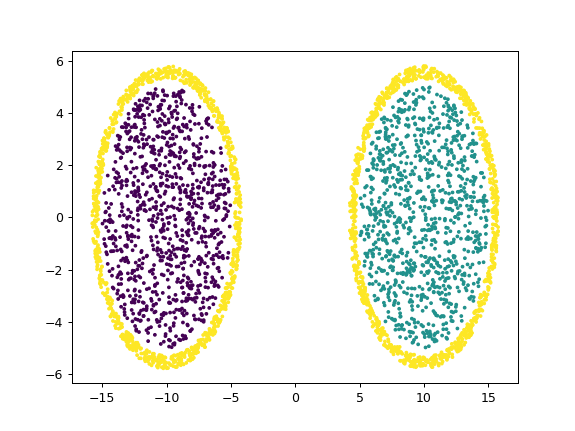

Plot of input data


In [49]:
# Plot input data
data = np.concatenate((classifier.data, classifier.data_out), axis=0)
labels = np.concatenate((classifier.labels, classifier.labels_out), axis=0)
fig=plt.figure()
plt.scatter(data[:, 0], data[:, 1], s=4, c=labels.squeeze())
print("Plot of input data")
plt.show()

<IPython.core.display.Javascript object>


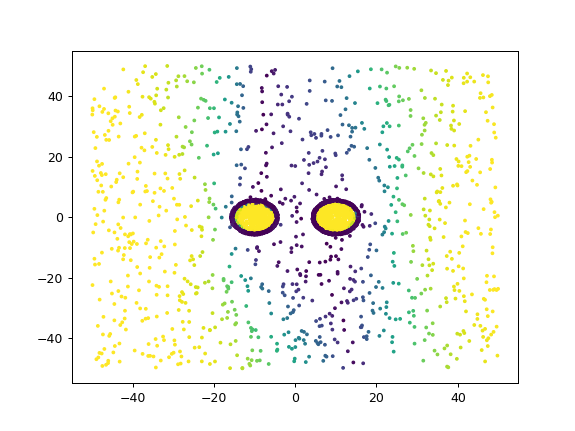

In [52]:
# Plot classified data - for test data

X_test = np.concatenate((classifier.X_test, classifier.X_test_out, classifier.data_outlier), axis=0)
y_test = np.concatenate((classifier.y_test, classifier.y_test_out, classifier.labels_outlier), axis=0)

#X_test = np.concatenate((classifier.X_test, classifier.data_outlier), axis=0)
#y_test = np.concatenate((classifier.y_test, classifier.labels_outlier), axis=0)


#X_test = np.concatenate((classifier.X_test, classifier.X_test_outliers), axis=0)
#y_test = np.concatenate((classifier.y_test, classifier.y_test_outliers), axis=0)

#X_test = classifier.data_outlier
#y_test = classifier.labels_outlier

y_pred = classifier.model.predict(X_test)
y_max = y_pred.max(axis = -1)

# Plot classified data - for test data

y_labels = y_pred.argmax(axis = -1)

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

#ax.scatter(X_test[:, 0], X_test[:, 1], y_max, c=y_test.squeeze())
plt.scatter(X_test[:, 0], X_test[:, 1], s=4, c=y_max.squeeze())
plt.show()

In [54]:
# Create image for paper
classifier.n = 400
data, labels, data_out, labels_out = classifier.get_data()
ind_0 = np.where(labels==0)[0][0:50]
ind_1 = np.where(labels==1)[0][0:50]
ind_2 = np.where(labels_out==2)[0]
ind = np.random.randint(0, ind_2.shape[0], 50)
ind_2 = ind_2[ind]
data = np.concatenate((data[ind_0,:], data[ind_1,:], data_out[ind_2,:]), axis=0)
labels = np.concatenate((labels[ind_0,:], labels[ind_1,:], labels_out[ind_2,:]), axis=0)
data_outlier, labels_outlier = classifier.get_outlier_data()
data = np.concatenate((data, data_outlier), axis=0)
labels = np.concatenate((labels, labels_outlier))
print(data.shape)
print(labels.shape)

(400, 1)
(800, 1)
(800, 1)
(550, 2)
(550, 1)


<IPython.core.display.Javascript object>


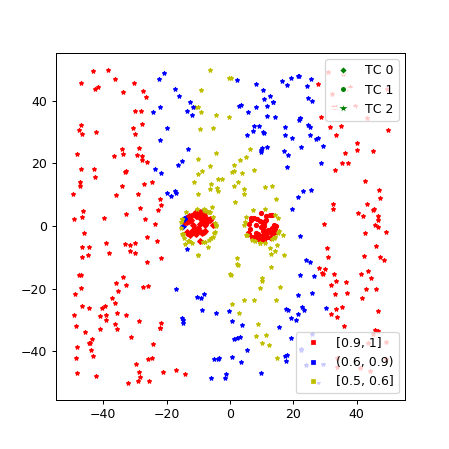

In [59]:
y_pred = classifier.model.predict(data)
y_labels = y_pred.argmax(axis = -1)
y_max = y_pred.max(axis = -1)

ind = np.where(y_max <= 0.6)[0]
y_labels[ind] = 2

ind = np.where(y_max >= 0.6)[0]
y_labels[ind] = 0

ind = np.where(((y_max > 0.6) & (y_max < 0.9)))[0]
y_labels[ind] = 1


c_list = ['r', 'b', 'y']
marker_list = ['D', 'o', '*']
plt.figure(figsize=(5,5))
for i in range(0, data.shape[0]):
    marker = marker_list[int(labels[i])]
    c = c_list[y_labels[i]]
    plt.scatter(data[i, 0], data[i, 1], s=10, c=c, marker=marker)

plt.legend(('$class\ 0$','$class\ 1$','$OOD\ sample$'), fontsize='x-small');
import matplotlib.lines as lines
dimond_line = lines.Line2D([0], [0], color='w', marker='D', markerfacecolor='g',
                          markersize=5, label='TC 0')

circle_line = lines.Line2D([0], [0], marker='o', color='w', label='TC 1',
                          markerfacecolor='g', markersize=5)

star_line = lines.Line2D([0], [0], color='w', marker='*', markerfacecolor='g',
                          markersize=10, label='TC 2')


red_line = lines.Line2D([0], [0], marker='s', color='w', label='[0.9, 1]',
                          markerfacecolor='r', markersize=5)


blue_line = lines.Line2D([0], [0], marker='s', color='w', label='(0.6, 0.9)',
                          markerfacecolor='b', markersize=5)


yellow_line = lines.Line2D([0], [0], marker='s', color='w', label='[0.5, 0.6]',
                          markerfacecolor='y', markersize=5)

# Create a legend for the first line.
first_legend = plt.legend(handles=[dimond_line, circle_line, star_line], loc=1)


# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=[red_line, blue_line, yellow_line], loc=4)

plt.show()
plt.savefig("exp1_b")

In [ ]:
count = 0
n = 1000
data = np.zeros((n, classifier.input_dim))
while count < n:
 p = classifier.sample_point_from_square(classifier.s)
 if (not classifier.is_in_hypersphere_centered_at(classifier.x1, classifier.r, p)) and (not classifier.is_in_hypersphere_centered_at(classifier.x2, classifier.r,p)):
  data[count, :] = p
  count += 1

plt.close()
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1])

In [ ]:
print(y_max.shape)
print(np.where(y_max>0.95)[0].shape)
print(np.where(y_max<0.55)[0].shape)

In [ ]:
print(classifier.data_outlier.shape)

In [ ]:
print(X_test.shape)
print(y_max.shape)
print(y_test.shape)